In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

##  Set the System Path

To keep the project modular and organized, the core functionalities such as dataset loading, model architecture, training utilities, and metrics are separated into individual Python scripts inside a folder named `simplenet-module`.

This section begins by appending the `simplenet-module` directory to the system path using `sys.path.append`. This allows us to import all necessary modules and helper functions stored in this folder directly into the notebook.

In [23]:
import sys
sys.path.append("/kaggle/input/simplenet-module")

## Import the Helper Modules
The imported modules include:
- `backbones.py`: Contains code to load and configure pretrained feature extractors like WideResNet.
- `resnet.py`: Implementation details specific to the ResNet backbone variants.
- `common.py`: Shared utility functions and constants used throughout the training and evaluation pipeline.
- `utils.py`: Functions for image visualization, directory management, and other utilities.
- `mvtec.py`: Custom dataset class to load and preprocess data from the MVTec AD dataset.
- `metrics.py`: Functions to calculate AUROC, AUPRO, and other performance metrics.

By keeping these components modular, the codebase remains clean, maintainable, and easier to debug or extend for future experimentation.

In [24]:
from backbones import *
from common import *
from metrics import *
from resnet import *
from utils import *
from mvtec import *
import logging
import os
import pickle
from collections import OrderedDict
import backbones
import common
import utils
import resnet
import utils
import mvtec

import math
import numpy as np
import torch
import torch.nn.functional as F
import tqdm
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import io
from PIL import Image

import common
import metrics
from utils import plot_segmentation_images

LOGGER = logging.getLogger(__name__)

## SimpleNet Architecture

The architecture consists of the following main components:

- **Pretrained Backbone (Feature Extractor)**  
  A WideResNet50 network is used to extract deep feature maps from intermediate layers (`layer2` and `layer3`). These layers capture multi-scale information crucial for detecting both global and local defects. The backbone weights remain frozen during training.

- **Feature Adapter**  
  A 1×1 convolution (or MLP) is applied to the extracted features to adapt them to a new feature space where anomaly detection is more effective. This module acts as a linear projector that reduces domain bias and aligns normal features more tightly.

- **Anomalous Feature Generator (only during training)**  
  During training, Gaussian noise is added to the adapted features to simulate anomalous patterns. These synthesized “anomalous” features help the model learn a decision boundary without requiring real anomalous examples, enabling fully unsupervised learning.

- **Discriminator**  
  A lightweight MLP discriminator is trained to separate real (adapted) features from the synthetic (noisy) ones. Its feedback is used to guide the feature adapter toward creating a compact and discriminative feature space.

- **Truncated L1 Loss**  
  Instead of a traditional adversarial loss, a custom L1 margin loss is used between the discriminator outputs of real and synthetic features. The margin helps stabilize training and encourages better separation.

- **Inference Phase**  
  At test time, no synthetic anomalies are generated. The input is passed through the backbone and adapter, and the discriminator’s output is used to produce an anomaly map. This score map is upsampled to the original resolution for visualization and pixel-level localization.


In [25]:
def init_weight(m):

    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
    elif isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)


class Discriminator(torch.nn.Module):
    def __init__(self, in_planes, n_layers=1, hidden=None):
        super(Discriminator, self).__init__()

        _hidden = in_planes if hidden is None else hidden
        self.body = torch.nn.Sequential()
        for i in range(n_layers-1):
            _in = in_planes if i == 0 else _hidden
            _hidden = int(_hidden // 1.5) if hidden is None else hidden
            self.body.add_module('block%d'%(i+1),
                                 torch.nn.Sequential(
                                     torch.nn.Linear(_in, _hidden),
                                     torch.nn.BatchNorm1d(_hidden),
                                     torch.nn.LeakyReLU(0.2)
                                 ))
        self.tail = torch.nn.Linear(_hidden, 1, bias=False)
        self.apply(init_weight)

    def forward(self,x):
        x = self.body(x)
        x = self.tail(x)
        return x


class Projection(torch.nn.Module):
    
    def __init__(self, in_planes, out_planes=None, n_layers=1, layer_type=0):
        super(Projection, self).__init__()
        
        if out_planes is None:
            out_planes = in_planes
        self.layers = torch.nn.Sequential()
        _in = None
        _out = None
        for i in range(n_layers):
            _in = in_planes if i == 0 else _out
            _out = out_planes 
            self.layers.add_module(f"{i}fc", 
                                   torch.nn.Linear(_in, _out))
            if i < n_layers - 1:
                # if layer_type > 0:
                #     self.layers.add_module(f"{i}bn", 
                #                            torch.nn.BatchNorm1d(_out))
                if layer_type > 1:
                    self.layers.add_module(f"{i}relu",
                                           torch.nn.LeakyReLU(.2))
        self.apply(init_weight)
    
    def forward(self, x):
        
        # x = .1 * self.layers(x) + x
        x = self.layers(x)
        return x


class TBWrapper:
    
    def __init__(self, log_dir):
        self.g_iter = 0
        self.logger = SummaryWriter(log_dir=log_dir)
    
    def step(self):
        self.g_iter += 1

class SimpleNet(torch.nn.Module):
    def __init__(self, device):
        """anomaly detection class."""
        super(SimpleNet, self).__init__()
        self.device = device

    def load(
        self,
        backbone,
        layers_to_extract_from,
        device,
        input_shape,
        pretrain_embed_dimension, # 1536
        target_embed_dimension, # 1536
        patchsize=3, # 3
        patchstride=1, 
        embedding_size=None, # 256
        meta_epochs=25, # 40
        aed_meta_epochs=15,
        gan_epochs=4, # 4
        noise_std=0.05,
        mix_noise=1,
        noise_type="GAU",
        dsc_layers=2, # 2
        dsc_hidden=None, # 1024
        dsc_margin=.8, # .5
        dsc_lr=0.0002,
        train_backbone=False,
        auto_noise=0,
        cos_lr=False,
        lr=1e-3,
        pre_proj=0, # 1
        proj_layer_type=0,
        **kwargs,
    ):
        pid = os.getpid()
        def show_mem():
            return(psutil.Process(pid).memory_info())

        self.backbone = backbone.to(device)
        self.layers_to_extract_from = layers_to_extract_from
        self.input_shape = input_shape

        self.device = device
        self.patch_maker = PatchMaker(patchsize, stride=patchstride)

        self.forward_modules = torch.nn.ModuleDict({})

        feature_aggregator = common.NetworkFeatureAggregator(
            self.backbone, self.layers_to_extract_from, self.device, train_backbone
        )
        feature_dimensions = feature_aggregator.feature_dimensions(input_shape)
        self.forward_modules["feature_aggregator"] = feature_aggregator

        preprocessing = common.Preprocessing(
            feature_dimensions, pretrain_embed_dimension
        )
        self.forward_modules["preprocessing"] = preprocessing

        self.target_embed_dimension = target_embed_dimension
        preadapt_aggregator = common.Aggregator(
            target_dim=target_embed_dimension
        )

        _ = preadapt_aggregator.to(self.device)

        self.forward_modules["preadapt_aggregator"] = preadapt_aggregator

        self.anomaly_segmentor = common.RescaleSegmentor(
            device=self.device, target_size=input_shape[-2:]
        )

        self.embedding_size = embedding_size if embedding_size is not None else self.target_embed_dimension
        self.meta_epochs = meta_epochs
        self.lr = lr
        self.cos_lr = cos_lr
        self.train_backbone = train_backbone
        if self.train_backbone:
            self.backbone_opt = torch.optim.AdamW(self.forward_modules["feature_aggregator"].backbone.parameters(), lr)
        # AED
        self.aed_meta_epochs = aed_meta_epochs

        self.pre_proj = pre_proj
        if self.pre_proj > 0:
            self.pre_projection = Projection(self.target_embed_dimension, self.target_embed_dimension, pre_proj, proj_layer_type)
            self.pre_projection.to(self.device)
            self.proj_opt = torch.optim.AdamW(self.pre_projection.parameters(), lr*.1)

        # Discriminator
        self.auto_noise = [auto_noise, None]
        self.dsc_lr = dsc_lr
        self.gan_epochs = gan_epochs
        self.mix_noise = mix_noise
        self.noise_type = noise_type
        self.noise_std = noise_std
        self.discriminator = Discriminator(self.target_embed_dimension, n_layers=dsc_layers, hidden=dsc_hidden)
        self.discriminator.to(self.device)
        self.dsc_opt = torch.optim.Adam(self.discriminator.parameters(), lr=self.dsc_lr, weight_decay=1e-5)
        self.dsc_schl = torch.optim.lr_scheduler.CosineAnnealingLR(self.dsc_opt, (meta_epochs - aed_meta_epochs) * gan_epochs, self.dsc_lr*.4)
        self.dsc_margin= dsc_margin 

        self.model_dir = ""
        self.dataset_name = ""
        self.tau = 1
        self.logger = None

    def set_model_dir(self, model_dir, dataset_name):

        self.model_dir = model_dir 
        os.makedirs(self.model_dir, exist_ok=True)
        self.ckpt_dir = os.path.join(self.model_dir, dataset_name)
        os.makedirs(self.ckpt_dir, exist_ok=True)
        self.tb_dir = os.path.join(self.ckpt_dir, "tb")
        os.makedirs(self.tb_dir, exist_ok=True)
        self.logger = TBWrapper(self.tb_dir) #SummaryWriter(log_dir=tb_dir)
    

    def embed(self, data):
        if isinstance(data, torch.utils.data.DataLoader):
            features = []
            for image in data:
                if isinstance(image, dict):
                    image = image["image"]
                    input_image = image.to(torch.float).to(self.device)
                with torch.no_grad():
                    features.append(self._embed(input_image))
            return features
        return self._embed(data)

    def _embed(self, images, detach=True, provide_patch_shapes=False, evaluation=False):
        """Returns feature embeddings for images."""

        B = len(images)
        if not evaluation and self.train_backbone:
            self.forward_modules["feature_aggregator"].train()
            features = self.forward_modules["feature_aggregator"](images, eval=evaluation)
        else:
            _ = self.forward_modules["feature_aggregator"].eval()
            with torch.no_grad():
                features = self.forward_modules["feature_aggregator"](images)

        features = [features[layer] for layer in self.layers_to_extract_from]

        for i, feat in enumerate(features):
            if len(feat.shape) == 3:
                B, L, C = feat.shape
                features[i] = feat.reshape(B, int(math.sqrt(L)), int(math.sqrt(L)), C).permute(0, 3, 1, 2)

        features = [
            self.patch_maker.patchify(x, return_spatial_info=True) for x in features
        ]
        patch_shapes = [x[1] for x in features]
        features = [x[0] for x in features]
        ref_num_patches = patch_shapes[0]

        for i in range(1, len(features)):
            _features = features[i]
            patch_dims = patch_shapes[i]

            # TODO(pgehler): Add comments
            _features = _features.reshape(
                _features.shape[0], patch_dims[0], patch_dims[1], *_features.shape[2:]
            )
            _features = _features.permute(0, -3, -2, -1, 1, 2)
            perm_base_shape = _features.shape
            _features = _features.reshape(-1, *_features.shape[-2:])
            _features = F.interpolate(
                _features.unsqueeze(1),
                size=(ref_num_patches[0], ref_num_patches[1]),
                mode="bilinear",
                align_corners=False,
            )
            _features = _features.squeeze(1)
            _features = _features.reshape(
                *perm_base_shape[:-2], ref_num_patches[0], ref_num_patches[1]
            )
            _features = _features.permute(0, -2, -1, 1, 2, 3)
            _features = _features.reshape(len(_features), -1, *_features.shape[-3:])
            features[i] = _features
        features = [x.reshape(-1, *x.shape[-3:]) for x in features]
        
        # As different feature backbones & patching provide differently
        # sized features, these are brought into the correct form here.
        features = self.forward_modules["preprocessing"](features) # pooling each feature to same channel and stack together
        features = self.forward_modules["preadapt_aggregator"](features) # further pooling        


        return features, patch_shapes

    
    def test(self, training_data, test_data, save_segmentation_images):

        ckpt_path = os.path.join(self.ckpt_dir, "models.ckpt")
        if os.path.exists(ckpt_path):
            state_dicts = torch.load(ckpt_path, map_location=self.device)
            if "pretrained_enc" in state_dicts:
                self.feature_enc.load_state_dict(state_dicts["pretrained_enc"])
            if "pretrained_dec" in state_dicts:
                self.feature_dec.load_state_dict(state_dicts["pretrained_dec"])

        aggregator = {"scores": [], "segmentations": [], "features": []}
        scores, segmentations, features, labels_gt, masks_gt = self.predict(test_data)
        aggregator["scores"].append(scores)
        aggregator["segmentations"].append(segmentations)
        aggregator["features"].append(features)

        scores = np.array(aggregator["scores"])
        min_scores = scores.min(axis=-1).reshape(-1, 1)
        max_scores = scores.max(axis=-1).reshape(-1, 1)
        scores = (scores - min_scores) / (max_scores - min_scores)
        scores = np.mean(scores, axis=0)

        segmentations = np.array(aggregator["segmentations"])
        min_scores = (
            segmentations.reshape(len(segmentations), -1)
            .min(axis=-1)
            .reshape(-1, 1, 1, 1)
        )
        max_scores = (
            segmentations.reshape(len(segmentations), -1)
            .max(axis=-1)
            .reshape(-1, 1, 1, 1)
        )
        segmentations = (segmentations - min_scores) / (max_scores - min_scores)
        segmentations = np.mean(segmentations, axis=0)

        anomaly_labels = [
            x[1] != "good" for x in test_data.dataset.data_to_iterate
        ]

        if save_segmentation_images:
            self.save_segmentation_images(test_data, segmentations, scores)
            
        auroc = metrics.compute_imagewise_retrieval_metrics(
            scores, anomaly_labels
        )["auroc"]

        # Compute PRO score & PW Auroc for all images
        pixel_scores = metrics.compute_pixelwise_retrieval_metrics(
            segmentations, masks_gt
        )
        full_pixel_auroc = pixel_scores["auroc"]

        return auroc, full_pixel_auroc
    
    def _evaluate(self, test_data, scores, segmentations, features, labels_gt, masks_gt):
        
        scores = np.squeeze(np.array(scores))
        img_min_scores = scores.min(axis=-1)
        img_max_scores = scores.max(axis=-1)
        scores = (scores - img_min_scores) / (img_max_scores - img_min_scores)
        # scores = np.mean(scores, axis=0)

        auroc = metrics.compute_imagewise_retrieval_metrics(
            scores, labels_gt 
        )["auroc"]

        if len(masks_gt) > 0:
            segmentations = np.array(segmentations)
            min_scores = (
                segmentations.reshape(len(segmentations), -1)
                .min(axis=-1)
                .reshape(-1, 1, 1, 1)
            )
            max_scores = (
                segmentations.reshape(len(segmentations), -1)
                .max(axis=-1)
                .reshape(-1, 1, 1, 1)
            )
            norm_segmentations = np.zeros_like(segmentations)
            for min_score, max_score in zip(min_scores, max_scores):
                norm_segmentations += (segmentations - min_score) / max(max_score - min_score, 1e-2)
            norm_segmentations = norm_segmentations / len(scores)


            # Compute PRO score & PW Auroc for all images
            pixel_scores = metrics.compute_pixelwise_retrieval_metrics(
                norm_segmentations, masks_gt)
                # segmentations, masks_gt
            full_pixel_auroc = pixel_scores["auroc"]

            pro = metrics.compute_pro(np.squeeze(np.array(masks_gt)), 
                                            norm_segmentations)
        else:
            full_pixel_auroc = -1 
            pro = -1

        return auroc, full_pixel_auroc, pro
        
    
    def train_model(self, training_data, test_data):

        
        state_dict = {}
        ckpt_path = os.path.join(self.ckpt_dir, "ckpt.pth")
        if os.path.exists(ckpt_path):
            state_dict = torch.load(ckpt_path, map_location=self.device)
            if 'discriminator' in state_dict:
                self.discriminator.load_state_dict(state_dict['discriminator'])
                if "pre_projection" in state_dict:
                    self.pre_projection.load_state_dict(state_dict["pre_projection"])
            else:
                self.load_state_dict(state_dict, strict=False)

            self.predict(training_data, "train_")
            scores, segmentations, features, labels_gt, masks_gt = self.predict(test_data)
            auroc, full_pixel_auroc, anomaly_pixel_auroc = self._evaluate(test_data, scores, segmentations, features, labels_gt, masks_gt)
            
            return auroc, full_pixel_auroc, anomaly_pixel_auroc
        
        def update_state_dict(d):
            
            state_dict["discriminator"] = OrderedDict({
                k:v.detach().cpu() 
                for k, v in self.discriminator.state_dict().items()})
            if self.pre_proj > 0:
                state_dict["pre_projection"] = OrderedDict({
                    k:v.detach().cpu() 
                    for k, v in self.pre_projection.state_dict().items()})

        best_record = None
        for i_mepoch in range(self.meta_epochs):

            self._train_discriminator(training_data)

            # torch.cuda.empty_cache()
            scores, segmentations, features, labels_gt, masks_gt = self.predict(test_data)
            auroc, full_pixel_auroc, pro = self._evaluate(test_data, scores, segmentations, features, labels_gt, masks_gt)
            self.logger.logger.add_scalar("i-auroc", auroc, i_mepoch)
            self.logger.logger.add_scalar("p-auroc", full_pixel_auroc, i_mepoch)
            self.logger.logger.add_scalar("pro", pro, i_mepoch)

            if best_record is None:
                best_record = [auroc, full_pixel_auroc, pro]
                update_state_dict(state_dict)
                # state_dict = OrderedDict({k:v.detach().cpu() for k, v in self.state_dict().items()})
            else:
                if auroc > best_record[0]:
                    best_record = [auroc, full_pixel_auroc, pro]
                    update_state_dict(state_dict)
                    # state_dict = OrderedDict({k:v.detach().cpu() for k, v in self.state_dict().items()})
                elif auroc == best_record[0] and full_pixel_auroc > best_record[1]:
                    best_record[1] = full_pixel_auroc
                    best_record[2] = pro 
                    update_state_dict(state_dict)
                    # state_dict = OrderedDict({k:v.detach().cpu() for k, v in self.state_dict().items()})

            print(f"----- {i_mepoch} I-AUROC:{round(auroc, 4)}(MAX:{round(best_record[0], 4)})"
                  f"  P-AUROC{round(full_pixel_auroc, 4)}(MAX:{round(best_record[1], 4)}) -----"
                  f"  PRO-AUROC{round(pro, 4)}(MAX:{round(best_record[2], 4)}) -----")
        
        torch.save(state_dict, ckpt_path)
        
        return best_record
            

    def _train_discriminator(self, input_data):
        """Computes and sets the support features for SPADE."""
        _ = self.forward_modules.eval()
        
        if self.pre_proj > 0:
            self.pre_projection.train()
        self.discriminator.train()
        # self.feature_enc.eval()
        # self.feature_dec.eval()
        i_iter = 0
        LOGGER.info(f"Training discriminator...")
        with tqdm.tqdm(total=self.gan_epochs) as pbar:
            for i_epoch in range(self.gan_epochs):
                all_loss = []
                all_p_true = []
                all_p_fake = []
                all_p_interp = []
                embeddings_list = []
                for data_item in input_data:
                    self.dsc_opt.zero_grad()
                    if self.pre_proj > 0:
                        self.proj_opt.zero_grad()
                    # self.dec_opt.zero_grad()

                    i_iter += 1
                    img = data_item["image"]
                    img = img.to(torch.float).to(self.device)
                    if self.pre_proj > 0:
                        true_feats = self.pre_projection(self._embed(img, evaluation=False)[0])
                    else:
                        true_feats = self._embed(img, evaluation=False)[0]
                    
                    noise_idxs = torch.randint(0, self.mix_noise, torch.Size([true_feats.shape[0]]))
                    noise_one_hot = torch.nn.functional.one_hot(noise_idxs, num_classes=self.mix_noise).to(self.device) # (N, K)
                    noise = torch.stack([
                        torch.normal(0, self.noise_std * 1.1**(k), true_feats.shape)
                        for k in range(self.mix_noise)], dim=1).to(self.device) # (N, K, C)
                    noise = (noise * noise_one_hot.unsqueeze(-1)).sum(1)
                    fake_feats = true_feats + noise

                    scores = self.discriminator(torch.cat([true_feats, fake_feats]))
                    true_scores = scores[:len(true_feats)]
                    fake_scores = scores[len(fake_feats):]
                    
                    th = self.dsc_margin
                    p_true = (true_scores.detach() >= th).sum() / len(true_scores)
                    p_fake = (fake_scores.detach() < -th).sum() / len(fake_scores)
                    true_loss = torch.clip(-true_scores + th, min=0)
                    fake_loss = torch.clip(fake_scores + th, min=0)

                    self.logger.logger.add_scalar(f"p_true", p_true, self.logger.g_iter)
                    self.logger.logger.add_scalar(f"p_fake", p_fake, self.logger.g_iter)

                    loss = true_loss.mean() + fake_loss.mean()
                    self.logger.logger.add_scalar("loss", loss, self.logger.g_iter)
                    self.logger.step()

                    loss.backward()
                    if self.pre_proj > 0:
                        self.proj_opt.step()
                    if self.train_backbone:
                        self.backbone_opt.step()
                    self.dsc_opt.step()

                    loss = loss.detach().cpu() 
                    all_loss.append(loss.item())
                    all_p_true.append(p_true.cpu().item())
                    all_p_fake.append(p_fake.cpu().item())
                
                if len(embeddings_list) > 0:
                    self.auto_noise[1] = torch.cat(embeddings_list).std(0).mean(-1)
                
                if self.cos_lr:
                    self.dsc_schl.step()
                
                all_loss = sum(all_loss) / len(input_data)
                all_p_true = sum(all_p_true) / len(input_data)
                all_p_fake = sum(all_p_fake) / len(input_data)
                cur_lr = self.dsc_opt.state_dict()['param_groups'][0]['lr']
                pbar_str = f"epoch:{i_epoch} loss:{round(all_loss, 5)} "
                pbar_str += f"lr:{round(cur_lr, 6)}"
                pbar_str += f" p_true:{round(all_p_true, 3)} p_fake:{round(all_p_fake, 3)}"
                if len(all_p_interp) > 0:
                    pbar_str += f" p_interp:{round(sum(all_p_interp) / len(input_data), 3)}"
                pbar.set_description_str(pbar_str)
                pbar.update(1)


    def predict(self, data, prefix=""):
        if isinstance(data, torch.utils.data.DataLoader):
            return self._predict_dataloader(data, prefix)
        return self._predict(data)

    def _predict_dataloader(self, dataloader, prefix):
        """This function provides anomaly scores/maps for full dataloaders."""
        _ = self.forward_modules.eval()


        img_paths = []
        scores = []
        masks = []
        features = []
        labels_gt = []
        masks_gt = []
        from sklearn.manifold import TSNE

        with tqdm.tqdm(dataloader, desc="Inferring...", leave=False) as data_iterator:
            for data in data_iterator:
                if isinstance(data, dict):
                    labels_gt.extend(data["is_anomaly"].numpy().tolist())
                    if data.get("mask", None) is not None:
                        masks_gt.extend(data["mask"].numpy().tolist())
                    image = data["image"]
                    img_paths.extend(data['image_path'])
                _scores, _masks, _feats = self._predict(image)
                for score, mask, feat, is_anomaly in zip(_scores, _masks, _feats, data["is_anomaly"].numpy().tolist()):
                    scores.append(score)
                    masks.append(mask)

        return scores, masks, features, labels_gt, masks_gt

    def _predict(self, images):
        """Infer score and mask for a batch of images."""
        images = images.to(torch.float).to(self.device)
        _ = self.forward_modules.eval()

        batchsize = images.shape[0]
        if self.pre_proj > 0:
            self.pre_projection.eval()
        self.discriminator.eval()
        with torch.no_grad():
            features, patch_shapes = self._embed(images,
                                                 provide_patch_shapes=True, 
                                                 evaluation=True)
            if self.pre_proj > 0:
                features = self.pre_projection(features)

            # features = features.cpu().numpy()
            # features = np.ascontiguousarray(features.cpu().numpy())
            patch_scores = image_scores = -self.discriminator(features)
            patch_scores = patch_scores.cpu().numpy()
            image_scores = image_scores.cpu().numpy()

            image_scores = self.patch_maker.unpatch_scores(
                image_scores, batchsize=batchsize
            )
            image_scores = image_scores.reshape(*image_scores.shape[:2], -1)
            image_scores = self.patch_maker.score(image_scores)

            patch_scores = self.patch_maker.unpatch_scores(
                patch_scores, batchsize=batchsize
            )
            scales = patch_shapes[0]
            patch_scores = patch_scores.reshape(batchsize, scales[0], scales[1])
            features = features.reshape(batchsize, scales[0], scales[1], -1)
            masks, features = self.anomaly_segmentor.convert_to_segmentation(patch_scores, features)

        return list(image_scores), list(masks), list(features)

    @staticmethod
    def _params_file(filepath, prepend=""):
        return os.path.join(filepath, prepend + "params.pkl")

    def save_to_path(self, save_path: str, prepend: str = ""):
        LOGGER.info("Saving data.")
        self.anomaly_scorer.save(
            save_path, save_features_separately=False, prepend=prepend
        )
        params = {
            "backbone.name": self.backbone.name,
            "layers_to_extract_from": self.layers_to_extract_from,
            "input_shape": self.input_shape,
            "pretrain_embed_dimension": self.forward_modules[
                "preprocessing"
            ].output_dim,
            "target_embed_dimension": self.forward_modules[
                "preadapt_aggregator"
            ].target_dim,
            "patchsize": self.patch_maker.patchsize,
            "patchstride": self.patch_maker.stride,
            "anomaly_scorer_num_nn": self.anomaly_scorer.n_nearest_neighbours,
        }
        with open(self._params_file(save_path, prepend), "wb") as save_file:
            pickle.dump(params, save_file, pickle.HIGHEST_PROTOCOL)

    def save_segmentation_images(self, data, segmentations, scores):
        image_paths = [
            x[2] for x in data.dataset.data_to_iterate
        ]
        mask_paths = [
            x[3] for x in data.dataset.data_to_iterate
        ]

        def image_transform(image):
            in_std = np.array(
                data.dataset.transform_std
            ).reshape(-1, 1, 1)
            in_mean = np.array(
                data.dataset.transform_mean
            ).reshape(-1, 1, 1)
            image = data.dataset.transform_img(image)
            return np.clip(
                (image.numpy() * in_std + in_mean) * 255, 0, 255
            ).astype(np.uint8)

        def mask_transform(mask):
            return data.dataset.transform_mask(mask).numpy()

        plot_segmentation_images(
            './output',
            image_paths,
            segmentations,
            scores,
            mask_paths,
            image_transform=image_transform,
            mask_transform=mask_transform,
        )

# Image handling classes.
class PatchMaker:
    def __init__(self, patchsize, top_k=0, stride=None):
        self.patchsize = patchsize
        self.stride = stride
        self.top_k = top_k

    def patchify(self, features, return_spatial_info=False):
        """Convert a tensor into a tensor of respective patches.
        Args:
            x: [torch.Tensor, bs x c x w x h]
        Returns:
            x: [torch.Tensor, bs * w//stride * h//stride, c, patchsize,
            patchsize]
        """
        padding = int((self.patchsize - 1) / 2)
        unfolder = torch.nn.Unfold(
            kernel_size=self.patchsize, stride=self.stride, padding=padding, dilation=1
        )
        unfolded_features = unfolder(features)
        number_of_total_patches = []
        for s in features.shape[-2:]:
            n_patches = (
                s + 2 * padding - 1 * (self.patchsize - 1) - 1
            ) / self.stride + 1
            number_of_total_patches.append(int(n_patches))
        unfolded_features = unfolded_features.reshape(
            *features.shape[:2], self.patchsize, self.patchsize, -1
        )
        unfolded_features = unfolded_features.permute(0, 4, 1, 2, 3)

        if return_spatial_info:
            return unfolded_features, number_of_total_patches
        return unfolded_features

    def unpatch_scores(self, x, batchsize):
        return x.reshape(batchsize, -1, *x.shape[1:])

    def score(self, x):
        was_numpy = False
        if isinstance(x, np.ndarray):
            was_numpy = True
            x = torch.from_numpy(x)
        while x.ndim > 2:
            x = torch.max(x, dim=-1).values
        if x.ndim == 2:
            if self.top_k > 1:
                x = torch.topk(x, self.top_k, dim=1).values.mean(1)
            else:
                x = torch.max(x, dim=1).values
        if was_numpy:
            return x.numpy()
        return x


## Setup and Configuration

- **Logging:** Configured to show info-level messages to track progress and important events.
- **Data paths:**  
  - `data_path` points to the MVTec AD dataset location (`/kaggle/input/mvtec-ad`).  
  - `subdatasets` lists all categories used for training and testing.
- **Results saving:**  
  - Results will be stored under `/kaggle/working/results` in a structured folder created with `create_storage_folder`.
- **Device setup:**  
  - The training and evaluation will use GPU device `0` if available, set via `set_torch_device`.


In [26]:
logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

# Set paths
data_path = "/kaggle/input/mvtec-ad" #Change the path to your dataset
subdatasets = ["bottle", "cable", "capsule", "carpet", "grid", "hazelnut", 
               "leather", "metal_nut", "pill", "screw", "tile", "toothbrush",
               "transistor", "wood", "zipper"]  
results_path = "/kaggle/working/results"
log_project = "simplenet_mvtec"
log_group = "bottle_test"
run_name = "run1"
run_save_path = create_storage_folder(results_path, log_project, log_group, run_name, mode="overwrite")

# Device
device = set_torch_device([0])


## Data Loading for MVTec AD Subdatasets

- Define a function `get_dataloaders` to prepare data loaders for each MVTec AD subdataset.
- For each subdataset:
  - Create a training dataset with data augmentation disabled and a 100% training split.
  - Create a testing dataset without augmentation.
  - Wrap both datasets into PyTorch `DataLoader` objects with batch size 8 and appropriate shuffling.
  - Assign a descriptive name to each training dataloader.
- Return a list of dictionaries containing training and testing dataloaders for all subdatasets.
- Initialize the dataloaders by calling `get_dataloaders` with a fixed random seed.


In [27]:
def get_dataloaders(seed=0):
    dataloaders = []
    for subdataset in subdatasets:
        train_dataset = MVTecDataset(
            data_path,
            classname=subdataset,
            resize=256,
            train_val_split=1.0,
            imagesize=224,
            split=DatasetSplit.TRAIN,
            seed=seed,
            augment=False
        )

        test_dataset = MVTecDataset(
            data_path,
            classname=subdataset,
            resize=256,
            imagesize=224,
            split=DatasetSplit.TEST,
            seed=seed,
        )

        train_dataloader = torch.utils.data.DataLoader(
            train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True
        )
        test_dataloader = torch.utils.data.DataLoader(
            test_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True
        )

        train_dataloader.name = "mvtec_" + subdataset

        dataloaders.append({
            "training": train_dataloader,
            "validation": None,
            "testing": test_dataloader
        })
    return dataloaders

dataloaders = get_dataloaders(seed=0)

## SimpleNet Model Training and Evaluation

- Initialize the SimpleNet model with a WideResNet50 backbone and specified hyperparameters.
- Iterate over each MVTec AD subdataset for training and testing.
- Fix random seeds before training to ensure reproducibility.
- Clear GPU cache if CUDA is available to optimize memory usage.
- Train the model on the training dataset and evaluate on the test dataset.
- Collect and store the best AUROC scores for instance-level, pixel-level, and anomaly pixel-level detection.


In [8]:
# def get_simplenet(input_shape, device):
#     backbone_name = "wideresnet50"
#     layers_to_extract_from = ["layer2", "layer3"]

#     backbone = backbones.load(backbone_name)
#     backbone.name, backbone.seed = backbone_name, None

#     sn = SimpleNet(device)
#     sn.load(
#         backbone=backbone,
#         layers_to_extract_from=layers_to_extract_from,
#         device=device,
#         input_shape=input_shape,
#         pretrain_embed_dimension=1536,
#         target_embed_dimension=1536,  
#         patchsize=3,
#         embedding_size=256,
#         meta_epochs=15,
#         aed_meta_epochs=10,
#         gan_epochs=4,
#         noise_std=0.05,
#         dsc_layers=2,
#         dsc_hidden=None,
#         dsc_margin=0.8,
#         dsc_lr=0.0002,
#         auto_noise=0.0,
#         train_backbone=False,
#         cos_lr=True,
#         pre_proj=1,
#         proj_layer_type=0,
#         mix_noise=1,
#     )
#     return [sn]

# all_best_results = []
# for loaders in dataloaders:
#     LOGGER.info(f"Training on dataset: {loaders['training'].name}")
#     fix_seeds(0, device)
    
#     if torch.cuda.is_available():
#         torch.cuda.empty_cache()

#     input_shape = loaders["training"].dataset.imagesize
#     model_list = get_simplenet(input_shape=(3, 224, 224), device=device)
#     results = []
#     print(f"Starting training for {loaders['training'].name}")
#     for i, model in enumerate(model_list):
#         model.set_model_dir(os.path.join(run_save_path, f"{i}"), loaders["training"].name)
#         i_auroc, p_auroc, pro_auroc = model.train_model(loaders["training"], loaders["testing"])

#         results.append({
#             "dataset": loaders["training"].name,
#             "instance_auroc": i_auroc,
#             "pixel_auroc": p_auroc,
#             "anomaly_pixel_auroc": pro_auroc
#         })
#     best_result = max(results, key=lambda x: x["instance_auroc"])
#     all_best_results.append(best_result)
#     print(f"{loaders['training'].name} completed")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:00<00:00, 218MB/s] 


Starting training for mvtec_bottle


epoch:3 loss:0.00446 lr:0.000189 p_true:0.984 p_fake:0.986: 100%|██████████| 4/4 [00:30<00:00,  7.75s/it]


----- 0 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9795(MAX:0.9795) -----  PRO-AUROC0.9248(MAX:0.9248) -----


epoch:3 loss:0.00098 lr:0.000159 p_true:0.995 p_fake:0.996: 100%|██████████| 4/4 [00:31<00:00,  7.83s/it]


----- 1 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9799(MAX:0.9799) -----  PRO-AUROC0.9275(MAX:0.9275) -----


epoch:3 loss:0.00039 lr:0.000121 p_true:0.998 p_fake:0.998: 100%|██████████| 4/4 [00:32<00:00,  8.05s/it]


----- 2 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9799(MAX:0.9799) -----  PRO-AUROC0.9268(MAX:0.9268) -----


epoch:3 loss:0.0002 lr:9.1e-05 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:32<00:00,  8.19s/it]  


----- 3 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9804(MAX:0.9804) -----  PRO-AUROC0.9326(MAX:0.9326) -----


epoch:3 loss:0.00011 lr:8e-05 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:32<00:00,  8.15s/it]  


----- 4 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9803(MAX:0.9804) -----  PRO-AUROC0.9275(MAX:0.9326) -----


epoch:3 loss:0.00013 lr:9.1e-05 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:32<00:00,  8.17s/it]


----- 5 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9805(MAX:0.9805) -----  PRO-AUROC0.9294(MAX:0.9294) -----


epoch:3 loss:0.00013 lr:0.000121 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:32<00:00,  8.13s/it]


----- 6 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9806(MAX:0.9806) -----  PRO-AUROC0.9299(MAX:0.9299) -----


epoch:3 loss:9e-05 lr:0.000159 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:32<00:00,  8.11s/it]  


----- 7 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9807(MAX:0.9807) -----  PRO-AUROC0.9316(MAX:0.9316) -----


epoch:3 loss:0.0001 lr:0.000189 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:32<00:00,  8.15s/it]


----- 8 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9806(MAX:0.9807) -----  PRO-AUROC0.9259(MAX:0.9316) -----


epoch:3 loss:4e-05 lr:0.0002 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:32<00:00,  8.13s/it]  


----- 9 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9807(MAX:0.9807) -----  PRO-AUROC0.931(MAX:0.9316) -----


epoch:3 loss:4e-05 lr:0.000189 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:32<00:00,  8.13s/it]


----- 10 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9808(MAX:0.9808) -----  PRO-AUROC0.9309(MAX:0.9309) -----


epoch:3 loss:5e-05 lr:0.000159 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:32<00:00,  8.13s/it]


----- 11 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9808(MAX:0.9808) -----  PRO-AUROC0.9273(MAX:0.9273) -----


epoch:3 loss:4e-05 lr:0.000121 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:32<00:00,  8.10s/it]


----- 12 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9811(MAX:0.9811) -----  PRO-AUROC0.9334(MAX:0.9334) -----


epoch:3 loss:2e-05 lr:9.1e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:32<00:00,  8.10s/it] 


----- 13 I-AUROC:1.0(MAX:1.0)  P-AUROC0.981(MAX:0.9811) -----  PRO-AUROC0.9274(MAX:0.9334) -----


epoch:3 loss:3e-05 lr:8e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:32<00:00,  8.11s/it]  


----- 14 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9811(MAX:0.9811) -----  PRO-AUROC0.9297(MAX:0.9297) -----
mvtec_bottle completed


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for mvtec_cable


epoch:3 loss:0.01483 lr:0.000189 p_true:0.951 p_fake:0.96: 100%|██████████| 4/4 [00:38<00:00,  9.52s/it] 


----- 0 I-AUROC:0.9874(MAX:0.9874)  P-AUROC0.9655(MAX:0.9655) -----  PRO-AUROC0.8806(MAX:0.8806) -----


epoch:3 loss:0.00239 lr:0.000159 p_true:0.989 p_fake:0.99: 100%|██████████| 4/4 [00:36<00:00,  9.15s/it] 


----- 1 I-AUROC:0.9948(MAX:0.9948)  P-AUROC0.9695(MAX:0.9695) -----  PRO-AUROC0.8955(MAX:0.8955) -----


epoch:3 loss:0.00081 lr:0.000121 p_true:0.995 p_fake:0.996: 100%|██████████| 4/4 [00:36<00:00,  9.16s/it]


----- 2 I-AUROC:0.997(MAX:0.997)  P-AUROC0.9684(MAX:0.9684) -----  PRO-AUROC0.8971(MAX:0.8971) -----


epoch:3 loss:0.00041 lr:9.1e-05 p_true:0.997 p_fake:0.998: 100%|██████████| 4/4 [00:36<00:00,  9.10s/it] 


----- 3 I-AUROC:0.9979(MAX:0.9979)  P-AUROC0.9705(MAX:0.9705) -----  PRO-AUROC0.8976(MAX:0.8976) -----


epoch:3 loss:0.0003 lr:8e-05 p_true:0.998 p_fake:0.998: 100%|██████████| 4/4 [00:36<00:00,  9.03s/it]   


----- 4 I-AUROC:0.9978(MAX:0.9979)  P-AUROC0.9706(MAX:0.9705) -----  PRO-AUROC0.8978(MAX:0.8976) -----


epoch:3 loss:0.00021 lr:9.1e-05 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:36<00:00,  9.14s/it]


----- 5 I-AUROC:0.9978(MAX:0.9979)  P-AUROC0.9717(MAX:0.9705) -----  PRO-AUROC0.898(MAX:0.8976) -----


epoch:3 loss:0.00015 lr:0.000121 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:36<00:00,  9.06s/it]


----- 6 I-AUROC:0.9963(MAX:0.9979)  P-AUROC0.971(MAX:0.9705) -----  PRO-AUROC0.8955(MAX:0.8976) -----


epoch:3 loss:0.00025 lr:0.000159 p_true:0.998 p_fake:0.999: 100%|██████████| 4/4 [00:36<00:00,  9.03s/it]


----- 7 I-AUROC:0.9991(MAX:0.9991)  P-AUROC0.9714(MAX:0.9714) -----  PRO-AUROC0.9073(MAX:0.9073) -----


epoch:3 loss:0.0002 lr:0.000189 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:36<00:00,  9.11s/it] 


----- 8 I-AUROC:0.9983(MAX:0.9991)  P-AUROC0.972(MAX:0.9714) -----  PRO-AUROC0.8925(MAX:0.9073) -----


epoch:3 loss:0.00024 lr:0.0002 p_true:0.998 p_fake:0.999: 100%|██████████| 4/4 [00:36<00:00,  9.16s/it]  


----- 9 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9682(MAX:0.9682) -----  PRO-AUROC0.8944(MAX:0.8944) -----


epoch:3 loss:0.00017 lr:0.000189 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:36<00:00,  9.03s/it]


----- 10 I-AUROC:0.997(MAX:1.0)  P-AUROC0.9641(MAX:0.9682) -----  PRO-AUROC0.8882(MAX:0.8944) -----


epoch:3 loss:0.0002 lr:0.000159 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:36<00:00,  9.10s/it] 


----- 11 I-AUROC:0.9964(MAX:1.0)  P-AUROC0.9621(MAX:0.9682) -----  PRO-AUROC0.8879(MAX:0.8944) -----


epoch:3 loss:8e-05 lr:0.000121 p_true:0.999 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.18s/it]  


----- 12 I-AUROC:0.9978(MAX:1.0)  P-AUROC0.971(MAX:0.9682) -----  PRO-AUROC0.8976(MAX:0.8944) -----


epoch:3 loss:4e-05 lr:9.1e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.18s/it] 


----- 13 I-AUROC:0.9993(MAX:1.0)  P-AUROC0.9697(MAX:0.9682) -----  PRO-AUROC0.9009(MAX:0.8944) -----


epoch:3 loss:4e-05 lr:8e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.12s/it]  


----- 14 I-AUROC:0.9987(MAX:1.0)  P-AUROC0.9716(MAX:0.9682) -----  PRO-AUROC0.9011(MAX:0.8944) -----
mvtec_cable completed


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for mvtec_capsule


epoch:3 loss:0.00237 lr:0.000189 p_true:0.992 p_fake:0.992: 100%|██████████| 4/4 [00:36<00:00,  9.02s/it]


----- 0 I-AUROC:0.9274(MAX:0.9274)  P-AUROC0.9865(MAX:0.9865) -----  PRO-AUROC0.9103(MAX:0.9103) -----


epoch:3 loss:0.00062 lr:0.000159 p_true:0.997 p_fake:0.997: 100%|██████████| 4/4 [00:36<00:00,  9.10s/it]


----- 1 I-AUROC:0.9318(MAX:0.9318)  P-AUROC0.9869(MAX:0.9869) -----  PRO-AUROC0.8938(MAX:0.8938) -----


epoch:3 loss:0.00027 lr:0.000121 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:36<00:00,  9.04s/it]


----- 2 I-AUROC:0.9434(MAX:0.9434)  P-AUROC0.9877(MAX:0.9877) -----  PRO-AUROC0.9154(MAX:0.9154) -----


epoch:3 loss:0.00011 lr:9.1e-05 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:36<00:00,  9.00s/it] 


----- 3 I-AUROC:0.9414(MAX:0.9434)  P-AUROC0.9854(MAX:0.9877) -----  PRO-AUROC0.8843(MAX:0.9154) -----


epoch:3 loss:7e-05 lr:8e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.11s/it]        


----- 4 I-AUROC:0.9469(MAX:0.9469)  P-AUROC0.9873(MAX:0.9873) -----  PRO-AUROC0.909(MAX:0.909) -----


epoch:3 loss:6e-05 lr:9.1e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.07s/it]    


----- 5 I-AUROC:0.9454(MAX:0.9469)  P-AUROC0.9877(MAX:0.9873) -----  PRO-AUROC0.9107(MAX:0.909) -----


epoch:3 loss:4e-05 lr:0.000121 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.00s/it]


----- 6 I-AUROC:0.9489(MAX:0.9489)  P-AUROC0.988(MAX:0.988) -----  PRO-AUROC0.918(MAX:0.918) -----


epoch:3 loss:6e-05 lr:0.000159 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.07s/it] 


----- 7 I-AUROC:0.9458(MAX:0.9489)  P-AUROC0.9879(MAX:0.988) -----  PRO-AUROC0.9158(MAX:0.918) -----


epoch:3 loss:6e-05 lr:0.000189 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.05s/it]


----- 8 I-AUROC:0.9442(MAX:0.9489)  P-AUROC0.988(MAX:0.988) -----  PRO-AUROC0.912(MAX:0.918) -----


epoch:3 loss:9e-05 lr:0.0002 p_true:0.999 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.04s/it]


----- 9 I-AUROC:0.9553(MAX:0.9553)  P-AUROC0.9892(MAX:0.9892) -----  PRO-AUROC0.9317(MAX:0.9317) -----


epoch:3 loss:4e-05 lr:0.000189 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:35<00:00,  8.96s/it]      


----- 10 I-AUROC:0.9473(MAX:0.9553)  P-AUROC0.9873(MAX:0.9892) -----  PRO-AUROC0.9138(MAX:0.9317) -----


epoch:3 loss:2e-05 lr:0.000159 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:35<00:00,  8.98s/it]


----- 11 I-AUROC:0.9501(MAX:0.9553)  P-AUROC0.9877(MAX:0.9892) -----  PRO-AUROC0.9124(MAX:0.9317) -----


epoch:3 loss:2e-05 lr:0.000121 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.03s/it]


----- 12 I-AUROC:0.9493(MAX:0.9553)  P-AUROC0.9881(MAX:0.9892) -----  PRO-AUROC0.9199(MAX:0.9317) -----


epoch:3 loss:1e-05 lr:9.1e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.00s/it] 


----- 13 I-AUROC:0.9505(MAX:0.9553)  P-AUROC0.9878(MAX:0.9892) -----  PRO-AUROC0.9077(MAX:0.9317) -----


epoch:3 loss:0.0 lr:8e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:35<00:00,  8.84s/it]    


----- 14 I-AUROC:0.9462(MAX:0.9553)  P-AUROC0.987(MAX:0.9892) -----  PRO-AUROC0.8967(MAX:0.9317) -----
mvtec_capsule completed


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for mvtec_carpet


epoch:3 loss:0.001 lr:0.000189 p_true:0.995 p_fake:0.997: 100%|██████████| 4/4 [00:45<00:00, 11.30s/it]  


----- 0 I-AUROC:0.9651(MAX:0.9651)  P-AUROC0.9772(MAX:0.9772) -----  PRO-AUROC0.909(MAX:0.909) -----


epoch:3 loss:0.00021 lr:0.000159 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:44<00:00, 11.18s/it]


----- 1 I-AUROC:0.9683(MAX:0.9683)  P-AUROC0.9789(MAX:0.9789) -----  PRO-AUROC0.9086(MAX:0.9086) -----


epoch:3 loss:0.0001 lr:0.000121 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:45<00:00, 11.36s/it] 


----- 2 I-AUROC:0.9695(MAX:0.9695)  P-AUROC0.9784(MAX:0.9784) -----  PRO-AUROC0.9131(MAX:0.9131) -----


epoch:3 loss:6e-05 lr:9.1e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:45<00:00, 11.32s/it]   


----- 3 I-AUROC:0.9707(MAX:0.9707)  P-AUROC0.9795(MAX:0.9795) -----  PRO-AUROC0.9137(MAX:0.9137) -----


epoch:3 loss:4e-05 lr:8e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:44<00:00, 11.20s/it]  


----- 4 I-AUROC:0.9723(MAX:0.9723)  P-AUROC0.9795(MAX:0.9795) -----  PRO-AUROC0.9105(MAX:0.9105) -----


epoch:3 loss:2e-05 lr:9.1e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:44<00:00, 11.22s/it]


----- 5 I-AUROC:0.9719(MAX:0.9723)  P-AUROC0.9794(MAX:0.9795) -----  PRO-AUROC0.9123(MAX:0.9105) -----


epoch:3 loss:3e-05 lr:0.000121 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:44<00:00, 11.22s/it]


----- 6 I-AUROC:0.9707(MAX:0.9723)  P-AUROC0.9787(MAX:0.9795) -----  PRO-AUROC0.9116(MAX:0.9105) -----


epoch:3 loss:2e-05 lr:0.000159 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:44<00:00, 11.11s/it]


----- 7 I-AUROC:0.9715(MAX:0.9723)  P-AUROC0.9788(MAX:0.9795) -----  PRO-AUROC0.9113(MAX:0.9105) -----


epoch:3 loss:2e-05 lr:0.000189 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:44<00:00, 11.10s/it]


----- 8 I-AUROC:0.9755(MAX:0.9755)  P-AUROC0.9794(MAX:0.9794) -----  PRO-AUROC0.9167(MAX:0.9167) -----


epoch:3 loss:4e-05 lr:0.0002 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:45<00:00, 11.33s/it]  


----- 9 I-AUROC:0.9739(MAX:0.9755)  P-AUROC0.9802(MAX:0.9794) -----  PRO-AUROC0.9127(MAX:0.9167) -----


epoch:3 loss:3e-05 lr:0.000189 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:44<00:00, 11.12s/it]


----- 10 I-AUROC:0.9707(MAX:0.9755)  P-AUROC0.9784(MAX:0.9794) -----  PRO-AUROC0.9118(MAX:0.9167) -----


epoch:3 loss:2e-05 lr:0.000159 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:44<00:00, 11.13s/it]


----- 11 I-AUROC:0.9711(MAX:0.9755)  P-AUROC0.9781(MAX:0.9794) -----  PRO-AUROC0.9124(MAX:0.9167) -----


epoch:3 loss:1e-05 lr:0.000121 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:44<00:00, 11.17s/it]


----- 12 I-AUROC:0.9731(MAX:0.9755)  P-AUROC0.9773(MAX:0.9794) -----  PRO-AUROC0.9101(MAX:0.9167) -----


epoch:3 loss:1e-05 lr:9.1e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:44<00:00, 11.11s/it] 


----- 13 I-AUROC:0.9571(MAX:0.9755)  P-AUROC0.9763(MAX:0.9794) -----  PRO-AUROC0.9039(MAX:0.9167) -----


epoch:3 loss:1e-05 lr:8e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:44<00:00, 11.15s/it]  


----- 14 I-AUROC:0.9775(MAX:0.9775)  P-AUROC0.9808(MAX:0.9808) -----  PRO-AUROC0.9213(MAX:0.9213) -----
mvtec_carpet completed


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for mvtec_grid


epoch:3 loss:0.10504 lr:0.000189 p_true:0.846 p_fake:0.885: 100%|██████████| 4/4 [00:38<00:00,  9.58s/it]


----- 0 I-AUROC:0.9942(MAX:0.9942)  P-AUROC0.981(MAX:0.981) -----  PRO-AUROC0.9454(MAX:0.9454) -----


epoch:3 loss:0.01486 lr:0.000159 p_true:0.965 p_fake:0.972: 100%|██████████| 4/4 [00:38<00:00,  9.66s/it]


----- 1 I-AUROC:0.9891(MAX:0.9942)  P-AUROC0.9815(MAX:0.981) -----  PRO-AUROC0.9428(MAX:0.9454) -----


epoch:3 loss:0.00444 lr:0.000121 p_true:0.988 p_fake:0.989: 100%|██████████| 4/4 [00:37<00:00,  9.45s/it]


----- 2 I-AUROC:0.995(MAX:0.995)  P-AUROC0.9855(MAX:0.9855) -----  PRO-AUROC0.9501(MAX:0.9501) -----


epoch:3 loss:0.00157 lr:9.1e-05 p_true:0.994 p_fake:0.995: 100%|██████████| 4/4 [00:38<00:00,  9.63s/it] 


----- 3 I-AUROC:0.9933(MAX:0.995)  P-AUROC0.9853(MAX:0.9855) -----  PRO-AUROC0.9493(MAX:0.9501) -----


epoch:3 loss:0.00046 lr:8e-05 p_true:0.998 p_fake:0.998: 100%|██████████| 4/4 [00:38<00:00,  9.60s/it]  


----- 4 I-AUROC:0.9933(MAX:0.995)  P-AUROC0.9856(MAX:0.9855) -----  PRO-AUROC0.9503(MAX:0.9501) -----


epoch:3 loss:0.00094 lr:9.1e-05 p_true:0.995 p_fake:0.998: 100%|██████████| 4/4 [00:38<00:00,  9.58s/it]


----- 5 I-AUROC:0.99(MAX:0.995)  P-AUROC0.9854(MAX:0.9855) -----  PRO-AUROC0.9532(MAX:0.9501) -----


epoch:3 loss:0.00051 lr:0.000121 p_true:0.998 p_fake:0.998: 100%|██████████| 4/4 [00:37<00:00,  9.25s/it]


----- 6 I-AUROC:0.995(MAX:0.995)  P-AUROC0.9846(MAX:0.9855) -----  PRO-AUROC0.9472(MAX:0.9501) -----


epoch:3 loss:0.00044 lr:0.000159 p_true:0.998 p_fake:0.999: 100%|██████████| 4/4 [00:37<00:00,  9.36s/it]


----- 7 I-AUROC:0.9942(MAX:0.995)  P-AUROC0.9855(MAX:0.9855) -----  PRO-AUROC0.9503(MAX:0.9501) -----


epoch:3 loss:0.00049 lr:0.000189 p_true:0.998 p_fake:0.999: 100%|██████████| 4/4 [00:37<00:00,  9.26s/it]


----- 8 I-AUROC:0.9983(MAX:0.9983)  P-AUROC0.9835(MAX:0.9835) -----  PRO-AUROC0.9472(MAX:0.9472) -----


epoch:3 loss:0.00023 lr:0.0002 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:36<00:00,  9.20s/it]  


----- 9 I-AUROC:0.9908(MAX:0.9983)  P-AUROC0.9851(MAX:0.9835) -----  PRO-AUROC0.9522(MAX:0.9472) -----


epoch:3 loss:9e-05 lr:0.000189 p_true:0.999 p_fake:1.0: 100%|██████████| 4/4 [00:37<00:00,  9.26s/it]   


----- 10 I-AUROC:0.9908(MAX:0.9983)  P-AUROC0.9854(MAX:0.9835) -----  PRO-AUROC0.9489(MAX:0.9472) -----


epoch:3 loss:0.0117 lr:0.000159 p_true:0.973 p_fake:0.981: 100%|██████████| 4/4 [00:37<00:00,  9.26s/it] 


----- 11 I-AUROC:0.985(MAX:0.9983)  P-AUROC0.9695(MAX:0.9835) -----  PRO-AUROC0.9178(MAX:0.9472) -----


epoch:3 loss:0.00022 lr:0.000121 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:36<00:00,  9.21s/it]


----- 12 I-AUROC:0.9925(MAX:0.9983)  P-AUROC0.9843(MAX:0.9835) -----  PRO-AUROC0.9499(MAX:0.9472) -----


epoch:3 loss:5e-05 lr:9.1e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.24s/it] 


----- 13 I-AUROC:0.995(MAX:0.9983)  P-AUROC0.9851(MAX:0.9835) -----  PRO-AUROC0.9537(MAX:0.9472) -----


epoch:3 loss:3e-05 lr:8e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.22s/it]  


----- 14 I-AUROC:0.995(MAX:0.9983)  P-AUROC0.9847(MAX:0.9835) -----  PRO-AUROC0.9523(MAX:0.9472) -----
mvtec_grid completed


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for mvtec_hazelnut


epoch:3 loss:0.0048 lr:0.000189 p_true:0.984 p_fake:0.988: 100%|██████████| 4/4 [01:01<00:00, 15.49s/it] 


----- 0 I-AUROC:0.9589(MAX:0.9589)  P-AUROC0.9615(MAX:0.9615) -----  PRO-AUROC0.8029(MAX:0.8029) -----


epoch:3 loss:0.00109 lr:0.000159 p_true:0.996 p_fake:0.996: 100%|██████████| 4/4 [01:01<00:00, 15.41s/it]


----- 1 I-AUROC:0.985(MAX:0.985)  P-AUROC0.9743(MAX:0.9743) -----  PRO-AUROC0.8533(MAX:0.8533) -----


epoch:3 loss:0.00061 lr:0.000121 p_true:0.997 p_fake:0.998: 100%|██████████| 4/4 [01:00<00:00, 15.16s/it]


----- 2 I-AUROC:0.9746(MAX:0.985)  P-AUROC0.9685(MAX:0.9743) -----  PRO-AUROC0.8386(MAX:0.8533) -----


epoch:3 loss:0.00019 lr:9.1e-05 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:59<00:00, 14.88s/it] 


----- 3 I-AUROC:0.9868(MAX:0.9868)  P-AUROC0.9757(MAX:0.9757) -----  PRO-AUROC0.8565(MAX:0.8565) -----


epoch:3 loss:0.00013 lr:8e-05 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [01:00<00:00, 15.17s/it]  


----- 4 I-AUROC:0.9836(MAX:0.9868)  P-AUROC0.9748(MAX:0.9757) -----  PRO-AUROC0.8556(MAX:0.8565) -----


epoch:3 loss:8e-05 lr:9.1e-05 p_true:0.999 p_fake:1.0: 100%|██████████| 4/4 [01:00<00:00, 15.17s/it]   


----- 5 I-AUROC:0.9864(MAX:0.9868)  P-AUROC0.9754(MAX:0.9757) -----  PRO-AUROC0.8609(MAX:0.8565) -----


epoch:3 loss:9e-05 lr:0.000121 p_true:0.999 p_fake:1.0: 100%|██████████| 4/4 [00:59<00:00, 14.91s/it]    


----- 6 I-AUROC:0.9839(MAX:0.9868)  P-AUROC0.9718(MAX:0.9757) -----  PRO-AUROC0.8434(MAX:0.8565) -----


epoch:3 loss:0.00022 lr:0.000159 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:59<00:00, 14.96s/it]


----- 7 I-AUROC:0.9829(MAX:0.9868)  P-AUROC0.9657(MAX:0.9757) -----  PRO-AUROC0.8395(MAX:0.8565) -----


epoch:3 loss:9e-05 lr:0.000189 p_true:0.999 p_fake:1.0: 100%|██████████| 4/4 [00:59<00:00, 14.82s/it]    


----- 8 I-AUROC:0.99(MAX:0.99)  P-AUROC0.9775(MAX:0.9775) -----  PRO-AUROC0.8588(MAX:0.8588) -----


epoch:3 loss:6e-05 lr:0.0002 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:58<00:00, 14.72s/it]        


----- 9 I-AUROC:0.9854(MAX:0.99)  P-AUROC0.9697(MAX:0.9775) -----  PRO-AUROC0.8342(MAX:0.8588) -----


epoch:3 loss:0.00014 lr:0.000189 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [01:00<00:00, 15.17s/it]


----- 10 I-AUROC:0.9864(MAX:0.99)  P-AUROC0.9681(MAX:0.9775) -----  PRO-AUROC0.8304(MAX:0.8588) -----


epoch:3 loss:0.00014 lr:0.000159 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [01:01<00:00, 15.31s/it]


----- 11 I-AUROC:0.9725(MAX:0.99)  P-AUROC0.971(MAX:0.9775) -----  PRO-AUROC0.8269(MAX:0.8588) -----


epoch:3 loss:2e-05 lr:0.000121 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [01:00<00:00, 15.14s/it]      


----- 12 I-AUROC:0.9939(MAX:0.9939)  P-AUROC0.9752(MAX:0.9752) -----  PRO-AUROC0.8683(MAX:0.8683) -----


epoch:3 loss:1e-05 lr:9.1e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:59<00:00, 14.99s/it] 


----- 13 I-AUROC:0.99(MAX:0.9939)  P-AUROC0.9755(MAX:0.9752) -----  PRO-AUROC0.858(MAX:0.8683) -----


epoch:3 loss:1e-05 lr:8e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [01:00<00:00, 15.08s/it]  


----- 14 I-AUROC:0.9954(MAX:0.9954)  P-AUROC0.9749(MAX:0.9749) -----  PRO-AUROC0.8693(MAX:0.8693) -----
mvtec_hazelnut completed


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for mvtec_leather


epoch:3 loss:0.00078 lr:0.000189 p_true:0.996 p_fake:0.998: 100%|██████████| 4/4 [00:37<00:00,  9.38s/it]


----- 0 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9912(MAX:0.9912) -----  PRO-AUROC0.9633(MAX:0.9633) -----


epoch:3 loss:0.00024 lr:0.000159 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:36<00:00,  9.23s/it]


----- 1 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9918(MAX:0.9918) -----  PRO-AUROC0.9662(MAX:0.9662) -----


epoch:3 loss:0.00011 lr:0.000121 p_true:0.999 p_fake:1.0: 100%|██████████| 4/4 [00:40<00:00, 10.21s/it]  


----- 2 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9915(MAX:0.9918) -----  PRO-AUROC0.9642(MAX:0.9662) -----


epoch:3 loss:7e-05 lr:9.1e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.24s/it]   


----- 3 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9922(MAX:0.9922) -----  PRO-AUROC0.9665(MAX:0.9665) -----


epoch:3 loss:5e-05 lr:8e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.19s/it]  


----- 4 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9923(MAX:0.9923) -----  PRO-AUROC0.9683(MAX:0.9683) -----


epoch:3 loss:3e-05 lr:9.1e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:37<00:00,  9.43s/it]


----- 5 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9921(MAX:0.9923) -----  PRO-AUROC0.9686(MAX:0.9683) -----


epoch:3 loss:4e-05 lr:0.000121 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:37<00:00,  9.49s/it]


----- 6 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9922(MAX:0.9923) -----  PRO-AUROC0.9688(MAX:0.9683) -----


epoch:3 loss:2e-05 lr:0.000159 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:37<00:00,  9.44s/it]


----- 7 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9922(MAX:0.9923) -----  PRO-AUROC0.9688(MAX:0.9683) -----


epoch:3 loss:2e-05 lr:0.000189 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:37<00:00,  9.36s/it]


----- 8 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9926(MAX:0.9926) -----  PRO-AUROC0.9683(MAX:0.9683) -----


epoch:3 loss:3e-05 lr:0.0002 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.19s/it]  


----- 9 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9926(MAX:0.9926) -----  PRO-AUROC0.9669(MAX:0.9683) -----


epoch:3 loss:1e-05 lr:0.000189 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:37<00:00,  9.42s/it]


----- 10 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9919(MAX:0.9926) -----  PRO-AUROC0.9651(MAX:0.9683) -----


epoch:3 loss:1e-05 lr:0.000159 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:37<00:00,  9.32s/it]


----- 11 I-AUROC:1.0(MAX:1.0)  P-AUROC0.992(MAX:0.9926) -----  PRO-AUROC0.971(MAX:0.9683) -----


epoch:3 loss:1e-05 lr:0.000121 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:37<00:00,  9.28s/it]


----- 12 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9922(MAX:0.9926) -----  PRO-AUROC0.9717(MAX:0.9683) -----


epoch:3 loss:1e-05 lr:9.1e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:37<00:00,  9.42s/it] 


----- 13 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9923(MAX:0.9926) -----  PRO-AUROC0.9719(MAX:0.9683) -----


epoch:3 loss:0.0 lr:8e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:37<00:00,  9.29s/it]    


----- 14 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9923(MAX:0.9926) -----  PRO-AUROC0.9712(MAX:0.9683) -----
mvtec_leather completed


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for mvtec_metal_nut


epoch:3 loss:0.01096 lr:0.000189 p_true:0.962 p_fake:0.97: 100%|██████████| 4/4 [00:30<00:00,  7.64s/it] 


----- 0 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9857(MAX:0.9857) -----  PRO-AUROC0.9033(MAX:0.9033) -----


epoch:3 loss:0.00193 lr:0.000159 p_true:0.991 p_fake:0.992: 100%|██████████| 4/4 [00:31<00:00,  7.78s/it]


----- 1 I-AUROC:1.0(MAX:1.0)  P-AUROC0.986(MAX:0.986) -----  PRO-AUROC0.8973(MAX:0.8973) -----


epoch:3 loss:0.00075 lr:0.000121 p_true:0.996 p_fake:0.996: 100%|██████████| 4/4 [00:31<00:00,  7.79s/it]


----- 2 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9861(MAX:0.9861) -----  PRO-AUROC0.8911(MAX:0.8911) -----


epoch:3 loss:0.00037 lr:9.1e-05 p_true:0.997 p_fake:0.998: 100%|██████████| 4/4 [00:31<00:00,  7.91s/it] 


----- 3 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9865(MAX:0.9865) -----  PRO-AUROC0.8947(MAX:0.8947) -----


epoch:3 loss:0.00023 lr:8e-05 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:31<00:00,  7.80s/it]  


----- 4 I-AUROC:0.9995(MAX:1.0)  P-AUROC0.9864(MAX:0.9865) -----  PRO-AUROC0.8954(MAX:0.8947) -----


epoch:3 loss:0.00045 lr:9.1e-05 p_true:0.997 p_fake:0.998: 100%|██████████| 4/4 [00:31<00:00,  7.76s/it]


----- 5 I-AUROC:0.9985(MAX:1.0)  P-AUROC0.9863(MAX:0.9865) -----  PRO-AUROC0.9051(MAX:0.8947) -----


epoch:3 loss:0.00014 lr:0.000121 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:31<00:00,  7.80s/it]


----- 6 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9863(MAX:0.9865) -----  PRO-AUROC0.9024(MAX:0.8947) -----


epoch:3 loss:0.00019 lr:0.000159 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:31<00:00,  7.83s/it]


----- 7 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9865(MAX:0.9865) -----  PRO-AUROC0.9025(MAX:0.9025) -----


epoch:3 loss:0.00015 lr:0.000189 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:31<00:00,  7.92s/it]


----- 8 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9863(MAX:0.9865) -----  PRO-AUROC0.9023(MAX:0.9025) -----


epoch:3 loss:0.00018 lr:0.0002 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:31<00:00,  7.81s/it]  


----- 9 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9856(MAX:0.9865) -----  PRO-AUROC0.907(MAX:0.9025) -----


epoch:3 loss:0.00026 lr:0.000189 p_true:0.998 p_fake:0.999: 100%|██████████| 4/4 [00:31<00:00,  7.77s/it]


----- 10 I-AUROC:1.0(MAX:1.0)  P-AUROC0.985(MAX:0.9865) -----  PRO-AUROC0.8871(MAX:0.9025) -----


epoch:3 loss:8e-05 lr:0.000159 p_true:0.999 p_fake:1.0: 100%|██████████| 4/4 [00:31<00:00,  7.80s/it]    


----- 11 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9845(MAX:0.9865) -----  PRO-AUROC0.8991(MAX:0.9025) -----


epoch:3 loss:4e-05 lr:0.000121 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:31<00:00,  7.86s/it]    


----- 12 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9852(MAX:0.9865) -----  PRO-AUROC0.9032(MAX:0.9025) -----


epoch:3 loss:5e-05 lr:9.1e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:31<00:00,  7.85s/it] 


----- 13 I-AUROC:1.0(MAX:1.0)  P-AUROC0.9865(MAX:0.9865) -----  PRO-AUROC0.9086(MAX:0.9025) -----


epoch:3 loss:2e-05 lr:8e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:30<00:00,  7.71s/it]  


----- 14 I-AUROC:0.999(MAX:1.0)  P-AUROC0.9862(MAX:0.9865) -----  PRO-AUROC0.9075(MAX:0.9025) -----
mvtec_metal_nut completed


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for mvtec_pill


epoch:3 loss:0.00287 lr:0.000189 p_true:0.99 p_fake:0.991: 100%|██████████| 4/4 [00:38<00:00,  9.71s/it] 


----- 0 I-AUROC:0.9108(MAX:0.9108)  P-AUROC0.968(MAX:0.968) -----  PRO-AUROC0.8834(MAX:0.8834) -----


epoch:3 loss:0.00061 lr:0.000159 p_true:0.997 p_fake:0.997: 100%|██████████| 4/4 [00:36<00:00,  9.20s/it]


----- 1 I-AUROC:0.9182(MAX:0.9182)  P-AUROC0.9731(MAX:0.9731) -----  PRO-AUROC0.8878(MAX:0.8878) -----


epoch:3 loss:0.00029 lr:0.000121 p_true:0.998 p_fake:0.998: 100%|██████████| 4/4 [00:37<00:00,  9.27s/it]


----- 2 I-AUROC:0.9416(MAX:0.9416)  P-AUROC0.9784(MAX:0.9784) -----  PRO-AUROC0.9123(MAX:0.9123) -----


epoch:3 loss:0.00013 lr:9.1e-05 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:37<00:00,  9.27s/it] 


----- 3 I-AUROC:0.937(MAX:0.9416)  P-AUROC0.9793(MAX:0.9784) -----  PRO-AUROC0.9136(MAX:0.9123) -----


epoch:3 loss:9e-05 lr:8e-05 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:37<00:00,  9.29s/it]    


----- 4 I-AUROC:0.9315(MAX:0.9416)  P-AUROC0.9781(MAX:0.9784) -----  PRO-AUROC0.9114(MAX:0.9123) -----


epoch:3 loss:6e-05 lr:9.1e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:37<00:00,  9.41s/it]    


----- 5 I-AUROC:0.9474(MAX:0.9474)  P-AUROC0.9785(MAX:0.9785) -----  PRO-AUROC0.9136(MAX:0.9136) -----


epoch:3 loss:7e-05 lr:0.000121 p_true:0.999 p_fake:1.0: 100%|██████████| 4/4 [00:37<00:00,  9.28s/it]  


----- 6 I-AUROC:0.9277(MAX:0.9474)  P-AUROC0.979(MAX:0.9785) -----  PRO-AUROC0.9097(MAX:0.9136) -----


epoch:3 loss:6e-05 lr:0.000159 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.23s/it] 


----- 7 I-AUROC:0.9392(MAX:0.9474)  P-AUROC0.9817(MAX:0.9785) -----  PRO-AUROC0.9211(MAX:0.9136) -----


epoch:3 loss:6e-05 lr:0.000189 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.24s/it]  


----- 8 I-AUROC:0.9217(MAX:0.9474)  P-AUROC0.9777(MAX:0.9785) -----  PRO-AUROC0.9077(MAX:0.9136) -----


epoch:3 loss:6e-05 lr:0.0002 p_true:0.999 p_fake:1.0: 100%|██████████| 4/4 [00:37<00:00,  9.29s/it]


----- 9 I-AUROC:0.9539(MAX:0.9539)  P-AUROC0.9775(MAX:0.9775) -----  PRO-AUROC0.9068(MAX:0.9068) -----


epoch:3 loss:4e-05 lr:0.000189 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:37<00:00,  9.27s/it]


----- 10 I-AUROC:0.9324(MAX:0.9539)  P-AUROC0.9784(MAX:0.9775) -----  PRO-AUROC0.9201(MAX:0.9068) -----


epoch:3 loss:3e-05 lr:0.000159 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.20s/it]


----- 11 I-AUROC:0.9585(MAX:0.9585)  P-AUROC0.9778(MAX:0.9778) -----  PRO-AUROC0.9073(MAX:0.9073) -----


epoch:3 loss:4e-05 lr:0.000121 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:37<00:00,  9.34s/it]


----- 12 I-AUROC:0.9414(MAX:0.9585)  P-AUROC0.9818(MAX:0.9778) -----  PRO-AUROC0.92(MAX:0.9073) -----


epoch:3 loss:1e-05 lr:9.1e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:37<00:00,  9.42s/it] 


----- 13 I-AUROC:0.9435(MAX:0.9585)  P-AUROC0.9808(MAX:0.9778) -----  PRO-AUROC0.9208(MAX:0.9073) -----


epoch:3 loss:1e-05 lr:8e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:37<00:00,  9.33s/it]  


----- 14 I-AUROC:0.9446(MAX:0.9585)  P-AUROC0.9832(MAX:0.9778) -----  PRO-AUROC0.9259(MAX:0.9073) -----
mvtec_pill completed


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for mvtec_screw


epoch:3 loss:0.00557 lr:0.000189 p_true:0.984 p_fake:0.986: 100%|██████████| 4/4 [00:45<00:00, 11.32s/it]


----- 0 I-AUROC:0.7069(MAX:0.7069)  P-AUROC0.93(MAX:0.93) -----  PRO-AUROC0.7573(MAX:0.7573) -----


epoch:3 loss:0.00096 lr:0.000159 p_true:0.996 p_fake:0.996: 100%|██████████| 4/4 [00:48<00:00, 12.09s/it]


----- 1 I-AUROC:0.85(MAX:0.85)  P-AUROC0.971(MAX:0.971) -----  PRO-AUROC0.8551(MAX:0.8551) -----


epoch:3 loss:0.00029 lr:0.000121 p_true:0.998 p_fake:0.999: 100%|██████████| 4/4 [00:47<00:00, 11.77s/it]


----- 2 I-AUROC:0.8979(MAX:0.8979)  P-AUROC0.9773(MAX:0.9773) -----  PRO-AUROC0.8844(MAX:0.8844) -----


epoch:3 loss:0.00017 lr:9.1e-05 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:48<00:00, 12.11s/it] 


----- 3 I-AUROC:0.8537(MAX:0.8979)  P-AUROC0.9721(MAX:0.9773) -----  PRO-AUROC0.8645(MAX:0.8844) -----


epoch:3 loss:0.00011 lr:8e-05 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:46<00:00, 11.61s/it]  


----- 4 I-AUROC:0.8723(MAX:0.8979)  P-AUROC0.9725(MAX:0.9773) -----  PRO-AUROC0.8502(MAX:0.8844) -----


epoch:3 loss:9e-05 lr:9.1e-05 p_true:0.999 p_fake:1.0: 100%|██████████| 4/4 [00:46<00:00, 11.58s/it]    


----- 5 I-AUROC:0.883(MAX:0.8979)  P-AUROC0.9728(MAX:0.9773) -----  PRO-AUROC0.8581(MAX:0.8844) -----


epoch:3 loss:9e-05 lr:0.000121 p_true:0.999 p_fake:1.0: 100%|██████████| 4/4 [00:46<00:00, 11.61s/it]   


----- 6 I-AUROC:0.9133(MAX:0.9133)  P-AUROC0.9713(MAX:0.9713) -----  PRO-AUROC0.853(MAX:0.853) -----


epoch:3 loss:0.00017 lr:0.000159 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:46<00:00, 11.69s/it]


----- 7 I-AUROC:0.8621(MAX:0.9133)  P-AUROC0.9594(MAX:0.9713) -----  PRO-AUROC0.7915(MAX:0.853) -----


epoch:3 loss:0.00065 lr:0.000189 p_true:0.997 p_fake:0.998: 100%|██████████| 4/4 [00:46<00:00, 11.68s/it]


----- 8 I-AUROC:0.8002(MAX:0.9133)  P-AUROC0.8811(MAX:0.9713) -----  PRO-AUROC0.661(MAX:0.853) -----


epoch:3 loss:5e-05 lr:0.0002 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:46<00:00, 11.62s/it]        


----- 9 I-AUROC:0.8344(MAX:0.9133)  P-AUROC0.9581(MAX:0.9713) -----  PRO-AUROC0.7937(MAX:0.853) -----


epoch:3 loss:2e-05 lr:0.000189 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:46<00:00, 11.65s/it]


----- 10 I-AUROC:0.9008(MAX:0.9133)  P-AUROC0.9745(MAX:0.9713) -----  PRO-AUROC0.8757(MAX:0.853) -----


epoch:3 loss:2e-05 lr:0.000159 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:46<00:00, 11.60s/it]


----- 11 I-AUROC:0.8916(MAX:0.9133)  P-AUROC0.9807(MAX:0.9713) -----  PRO-AUROC0.9004(MAX:0.853) -----


epoch:3 loss:1e-05 lr:0.000121 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:46<00:00, 11.56s/it]


----- 12 I-AUROC:0.8801(MAX:0.9133)  P-AUROC0.9773(MAX:0.9713) -----  PRO-AUROC0.8788(MAX:0.853) -----


epoch:3 loss:1e-05 lr:9.1e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:45<00:00, 11.43s/it] 


----- 13 I-AUROC:0.8768(MAX:0.9133)  P-AUROC0.9769(MAX:0.9713) -----  PRO-AUROC0.8635(MAX:0.853) -----


epoch:3 loss:1e-05 lr:8e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:45<00:00, 11.48s/it]  


----- 14 I-AUROC:0.8992(MAX:0.9133)  P-AUROC0.9806(MAX:0.9713) -----  PRO-AUROC0.8865(MAX:0.853) -----
mvtec_screw completed


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for mvtec_tile


epoch:3 loss:0.00341 lr:0.000189 p_true:0.985 p_fake:0.991: 100%|██████████| 4/4 [00:33<00:00,  8.42s/it]


----- 0 I-AUROC:0.9848(MAX:0.9848)  P-AUROC0.9318(MAX:0.9318) -----  PRO-AUROC0.8844(MAX:0.8844) -----


epoch:3 loss:0.00068 lr:0.000159 p_true:0.996 p_fake:0.997: 100%|██████████| 4/4 [00:34<00:00,  8.55s/it]


----- 1 I-AUROC:0.9848(MAX:0.9848)  P-AUROC0.9345(MAX:0.9345) -----  PRO-AUROC0.891(MAX:0.891) -----


epoch:3 loss:0.00029 lr:0.000121 p_true:0.998 p_fake:0.999: 100%|██████████| 4/4 [00:34<00:00,  8.60s/it]


----- 2 I-AUROC:0.9802(MAX:0.9848)  P-AUROC0.9392(MAX:0.9345) -----  PRO-AUROC0.8906(MAX:0.891) -----


epoch:3 loss:0.00014 lr:9.1e-05 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:34<00:00,  8.66s/it] 


----- 3 I-AUROC:0.9856(MAX:0.9856)  P-AUROC0.9419(MAX:0.9419) -----  PRO-AUROC0.894(MAX:0.894) -----


epoch:3 loss:0.0001 lr:8e-05 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:34<00:00,  8.51s/it]   


----- 4 I-AUROC:0.9841(MAX:0.9856)  P-AUROC0.9453(MAX:0.9419) -----  PRO-AUROC0.8973(MAX:0.894) -----


epoch:3 loss:0.00012 lr:9.1e-05 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:34<00:00,  8.58s/it]


----- 5 I-AUROC:0.9888(MAX:0.9888)  P-AUROC0.9429(MAX:0.9429) -----  PRO-AUROC0.8931(MAX:0.8931) -----


epoch:3 loss:5e-05 lr:0.000121 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:34<00:00,  8.55s/it]  


----- 6 I-AUROC:0.9863(MAX:0.9888)  P-AUROC0.9425(MAX:0.9429) -----  PRO-AUROC0.8948(MAX:0.8931) -----


epoch:3 loss:6e-05 lr:0.000159 p_true:0.999 p_fake:1.0: 100%|██████████| 4/4 [00:34<00:00,  8.52s/it]


----- 7 I-AUROC:0.9877(MAX:0.9888)  P-AUROC0.9417(MAX:0.9429) -----  PRO-AUROC0.8869(MAX:0.8931) -----


epoch:3 loss:8e-05 lr:0.000189 p_true:0.999 p_fake:1.0: 100%|██████████| 4/4 [00:34<00:00,  8.63s/it]


----- 8 I-AUROC:0.9906(MAX:0.9906)  P-AUROC0.9412(MAX:0.9412) -----  PRO-AUROC0.8964(MAX:0.8964) -----


epoch:3 loss:6e-05 lr:0.0002 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:34<00:00,  8.63s/it]    


----- 9 I-AUROC:0.9888(MAX:0.9906)  P-AUROC0.9409(MAX:0.9412) -----  PRO-AUROC0.888(MAX:0.8964) -----


epoch:3 loss:6e-05 lr:0.000189 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:34<00:00,  8.56s/it]  


----- 10 I-AUROC:0.9863(MAX:0.9906)  P-AUROC0.939(MAX:0.9412) -----  PRO-AUROC0.8863(MAX:0.8964) -----


epoch:3 loss:6e-05 lr:0.000159 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:34<00:00,  8.62s/it]


----- 11 I-AUROC:0.9845(MAX:0.9906)  P-AUROC0.9455(MAX:0.9412) -----  PRO-AUROC0.8901(MAX:0.8964) -----


epoch:3 loss:3e-05 lr:0.000121 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:34<00:00,  8.54s/it]


----- 12 I-AUROC:0.9859(MAX:0.9906)  P-AUROC0.9411(MAX:0.9412) -----  PRO-AUROC0.8933(MAX:0.8964) -----


epoch:3 loss:2e-05 lr:9.1e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:33<00:00,  8.38s/it] 


----- 13 I-AUROC:0.9877(MAX:0.9906)  P-AUROC0.9412(MAX:0.9412) -----  PRO-AUROC0.8952(MAX:0.8964) -----


epoch:3 loss:1e-05 lr:8e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:34<00:00,  8.63s/it]  


----- 14 I-AUROC:0.9827(MAX:0.9906)  P-AUROC0.9415(MAX:0.9412) -----  PRO-AUROC0.8899(MAX:0.8964) -----
mvtec_tile completed


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for mvtec_toothbrush


epoch:3 loss:0.09639 lr:0.000189 p_true:0.832 p_fake:0.868: 100%|██████████| 4/4 [00:11<00:00,  2.95s/it]


----- 0 I-AUROC:0.7667(MAX:0.7667)  P-AUROC0.5681(MAX:0.5681) -----  PRO-AUROC0.308(MAX:0.308) -----


epoch:3 loss:0.01495 lr:0.000159 p_true:0.957 p_fake:0.966: 100%|██████████| 4/4 [00:11<00:00,  2.84s/it]


----- 1 I-AUROC:0.9472(MAX:0.9472)  P-AUROC0.9476(MAX:0.9476) -----  PRO-AUROC0.7553(MAX:0.7553) -----


epoch:3 loss:0.00645 lr:0.000121 p_true:0.982 p_fake:0.98: 100%|██████████| 4/4 [00:11<00:00,  2.86s/it] 


----- 2 I-AUROC:0.9861(MAX:0.9861)  P-AUROC0.9798(MAX:0.9798) -----  PRO-AUROC0.8738(MAX:0.8738) -----


epoch:3 loss:0.00353 lr:9.1e-05 p_true:0.987 p_fake:0.987: 100%|██████████| 4/4 [00:11<00:00,  2.91s/it] 


----- 3 I-AUROC:0.9861(MAX:0.9861)  P-AUROC0.9802(MAX:0.9798) -----  PRO-AUROC0.8801(MAX:0.8738) -----


epoch:3 loss:0.00213 lr:8e-05 p_true:0.99 p_fake:0.992: 100%|██████████| 4/4 [00:11<00:00,  2.94s/it]  


----- 4 I-AUROC:0.9889(MAX:0.9889)  P-AUROC0.9814(MAX:0.9814) -----  PRO-AUROC0.8826(MAX:0.8826) -----


epoch:3 loss:0.00152 lr:9.1e-05 p_true:0.992 p_fake:0.993: 100%|██████████| 4/4 [00:11<00:00,  2.88s/it]


----- 5 I-AUROC:0.9889(MAX:0.9889)  P-AUROC0.9806(MAX:0.9814) -----  PRO-AUROC0.8677(MAX:0.8826) -----


epoch:3 loss:0.00106 lr:0.000121 p_true:0.995 p_fake:0.995: 100%|██████████| 4/4 [00:11<00:00,  2.83s/it]


----- 6 I-AUROC:0.9917(MAX:0.9917)  P-AUROC0.9822(MAX:0.9822) -----  PRO-AUROC0.8881(MAX:0.8881) -----


epoch:3 loss:0.00097 lr:0.000159 p_true:0.995 p_fake:0.995: 100%|██████████| 4/4 [00:11<00:00,  2.87s/it]


----- 7 I-AUROC:0.9889(MAX:0.9917)  P-AUROC0.982(MAX:0.9822) -----  PRO-AUROC0.8908(MAX:0.8881) -----


epoch:3 loss:0.00129 lr:0.000189 p_true:0.993 p_fake:0.995: 100%|██████████| 4/4 [00:11<00:00,  2.85s/it]


----- 8 I-AUROC:0.9861(MAX:0.9917)  P-AUROC0.9817(MAX:0.9822) -----  PRO-AUROC0.8855(MAX:0.8881) -----


epoch:3 loss:0.00068 lr:0.0002 p_true:0.996 p_fake:0.997: 100%|██████████| 4/4 [00:11<00:00,  2.90s/it]  


----- 9 I-AUROC:0.9833(MAX:0.9917)  P-AUROC0.9808(MAX:0.9822) -----  PRO-AUROC0.8814(MAX:0.8881) -----


epoch:3 loss:0.00254 lr:0.000189 p_true:0.986 p_fake:0.993: 100%|██████████| 4/4 [00:11<00:00,  2.87s/it]


----- 10 I-AUROC:0.9667(MAX:0.9917)  P-AUROC0.9804(MAX:0.9822) -----  PRO-AUROC0.8804(MAX:0.8881) -----


epoch:3 loss:0.00057 lr:0.000159 p_true:0.998 p_fake:0.997: 100%|██████████| 4/4 [00:11<00:00,  2.86s/it]


----- 11 I-AUROC:0.9861(MAX:0.9917)  P-AUROC0.9822(MAX:0.9822) -----  PRO-AUROC0.8862(MAX:0.8881) -----


epoch:3 loss:0.00024 lr:0.000121 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:11<00:00,  2.88s/it]


----- 12 I-AUROC:0.9861(MAX:0.9917)  P-AUROC0.9821(MAX:0.9822) -----  PRO-AUROC0.8953(MAX:0.8881) -----


epoch:3 loss:0.00026 lr:9.1e-05 p_true:0.998 p_fake:0.999: 100%|██████████| 4/4 [00:11<00:00,  2.90s/it] 


----- 13 I-AUROC:0.9861(MAX:0.9917)  P-AUROC0.9814(MAX:0.9822) -----  PRO-AUROC0.8944(MAX:0.8881) -----


epoch:3 loss:0.00011 lr:8e-05 p_true:1.0 p_fake:0.999: 100%|██████████| 4/4 [00:11<00:00,  2.96s/it]    


----- 14 I-AUROC:0.9889(MAX:0.9917)  P-AUROC0.9827(MAX:0.9822) -----  PRO-AUROC0.8944(MAX:0.8881) -----
mvtec_toothbrush completed


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for mvtec_transistor


epoch:3 loss:0.00827 lr:0.000189 p_true:0.974 p_fake:0.978: 100%|██████████| 4/4 [00:36<00:00,  9.06s/it]


----- 0 I-AUROC:0.9883(MAX:0.9883)  P-AUROC0.9647(MAX:0.9647) -----  PRO-AUROC0.8775(MAX:0.8775) -----


epoch:3 loss:0.00189 lr:0.000159 p_true:0.992 p_fake:0.993: 100%|██████████| 4/4 [00:35<00:00,  8.85s/it]


----- 1 I-AUROC:0.9929(MAX:0.9929)  P-AUROC0.9691(MAX:0.9691) -----  PRO-AUROC0.8926(MAX:0.8926) -----


epoch:3 loss:0.00048 lr:0.000121 p_true:0.997 p_fake:0.997: 100%|██████████| 4/4 [00:35<00:00,  8.89s/it]


----- 2 I-AUROC:0.9917(MAX:0.9929)  P-AUROC0.9713(MAX:0.9691) -----  PRO-AUROC0.8905(MAX:0.8926) -----


epoch:3 loss:0.00031 lr:9.1e-05 p_true:0.998 p_fake:0.998: 100%|██████████| 4/4 [00:35<00:00,  8.91s/it] 


----- 3 I-AUROC:0.995(MAX:0.995)  P-AUROC0.9707(MAX:0.9707) -----  PRO-AUROC0.8977(MAX:0.8977) -----


epoch:3 loss:0.00018 lr:8e-05 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:35<00:00,  8.93s/it]  


----- 4 I-AUROC:0.995(MAX:0.995)  P-AUROC0.9718(MAX:0.9718) -----  PRO-AUROC0.9047(MAX:0.9047) -----


epoch:3 loss:0.00012 lr:9.1e-05 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:35<00:00,  8.98s/it]


----- 5 I-AUROC:0.9946(MAX:0.995)  P-AUROC0.9726(MAX:0.9718) -----  PRO-AUROC0.8897(MAX:0.9047) -----


epoch:3 loss:0.00013 lr:0.000121 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:35<00:00,  8.96s/it]


----- 6 I-AUROC:0.9954(MAX:0.9954)  P-AUROC0.9706(MAX:0.9706) -----  PRO-AUROC0.9017(MAX:0.9017) -----


epoch:3 loss:0.00015 lr:0.000159 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:35<00:00,  8.81s/it]


----- 7 I-AUROC:0.9971(MAX:0.9971)  P-AUROC0.9724(MAX:0.9724) -----  PRO-AUROC0.9067(MAX:0.9067) -----


epoch:3 loss:0.00012 lr:0.000189 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:35<00:00,  8.97s/it]


----- 8 I-AUROC:0.9875(MAX:0.9971)  P-AUROC0.9685(MAX:0.9724) -----  PRO-AUROC0.8809(MAX:0.9067) -----


epoch:3 loss:0.00021 lr:0.0002 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:35<00:00,  8.90s/it]  


----- 9 I-AUROC:0.9896(MAX:0.9971)  P-AUROC0.9708(MAX:0.9724) -----  PRO-AUROC0.8905(MAX:0.9067) -----


epoch:3 loss:0.00013 lr:0.000189 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:35<00:00,  8.89s/it]


----- 10 I-AUROC:0.9971(MAX:0.9971)  P-AUROC0.9709(MAX:0.9724) -----  PRO-AUROC0.8892(MAX:0.9067) -----


epoch:3 loss:5e-05 lr:0.000159 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:35<00:00,  8.92s/it]    


----- 11 I-AUROC:0.9958(MAX:0.9971)  P-AUROC0.9722(MAX:0.9724) -----  PRO-AUROC0.9102(MAX:0.9067) -----


epoch:3 loss:4e-05 lr:0.000121 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:35<00:00,  8.87s/it]


----- 12 I-AUROC:0.9971(MAX:0.9971)  P-AUROC0.9717(MAX:0.9724) -----  PRO-AUROC0.8997(MAX:0.9067) -----


epoch:3 loss:4e-05 lr:9.1e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:35<00:00,  8.91s/it] 


----- 13 I-AUROC:0.9983(MAX:0.9983)  P-AUROC0.9731(MAX:0.9731) -----  PRO-AUROC0.9068(MAX:0.9068) -----


epoch:3 loss:3e-05 lr:8e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.02s/it]  


----- 14 I-AUROC:0.9962(MAX:0.9983)  P-AUROC0.9716(MAX:0.9731) -----  PRO-AUROC0.9064(MAX:0.9068) -----
mvtec_transistor completed


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for mvtec_wood


epoch:3 loss:0.00174 lr:0.000189 p_true:0.992 p_fake:0.995: 100%|██████████| 4/4 [00:38<00:00,  9.52s/it]


----- 0 I-AUROC:0.9904(MAX:0.9904)  P-AUROC0.9165(MAX:0.9165) -----  PRO-AUROC0.7757(MAX:0.7757) -----


epoch:3 loss:0.00054 lr:0.000159 p_true:0.997 p_fake:0.998: 100%|██████████| 4/4 [00:37<00:00,  9.33s/it]


----- 1 I-AUROC:0.9877(MAX:0.9904)  P-AUROC0.9224(MAX:0.9165) -----  PRO-AUROC0.7917(MAX:0.7757) -----


epoch:3 loss:0.00024 lr:0.000121 p_true:0.998 p_fake:0.999: 100%|██████████| 4/4 [00:37<00:00,  9.34s/it]


----- 2 I-AUROC:0.993(MAX:0.993)  P-AUROC0.9215(MAX:0.9215) -----  PRO-AUROC0.7874(MAX:0.7874) -----


epoch:3 loss:0.00015 lr:9.1e-05 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:37<00:00,  9.31s/it] 


----- 3 I-AUROC:0.9947(MAX:0.9947)  P-AUROC0.9216(MAX:0.9216) -----  PRO-AUROC0.7899(MAX:0.7899) -----


epoch:3 loss:7e-05 lr:8e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.22s/it]        


----- 4 I-AUROC:0.9947(MAX:0.9947)  P-AUROC0.924(MAX:0.924) -----  PRO-AUROC0.7941(MAX:0.7941) -----


epoch:3 loss:9e-05 lr:9.1e-05 p_true:0.999 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.18s/it]


----- 5 I-AUROC:0.9921(MAX:0.9947)  P-AUROC0.9267(MAX:0.924) -----  PRO-AUROC0.7986(MAX:0.7941) -----


epoch:3 loss:0.0002 lr:0.000121 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:37<00:00,  9.27s/it]


----- 6 I-AUROC:0.9939(MAX:0.9947)  P-AUROC0.9158(MAX:0.924) -----  PRO-AUROC0.7821(MAX:0.7941) -----


epoch:3 loss:4e-05 lr:0.000159 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:37<00:00,  9.32s/it]    


----- 7 I-AUROC:0.9965(MAX:0.9965)  P-AUROC0.9226(MAX:0.9226) -----  PRO-AUROC0.7923(MAX:0.7923) -----


epoch:3 loss:4e-05 lr:0.000189 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:37<00:00,  9.27s/it]


----- 8 I-AUROC:0.9956(MAX:0.9965)  P-AUROC0.9169(MAX:0.9226) -----  PRO-AUROC0.7853(MAX:0.7923) -----


epoch:3 loss:3e-05 lr:0.0002 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:37<00:00,  9.28s/it]    


----- 9 I-AUROC:0.9956(MAX:0.9965)  P-AUROC0.917(MAX:0.9226) -----  PRO-AUROC0.7813(MAX:0.7923) -----


epoch:3 loss:1e-05 lr:0.000189 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.13s/it]


----- 10 I-AUROC:0.9904(MAX:0.9965)  P-AUROC0.9201(MAX:0.9226) -----  PRO-AUROC0.7893(MAX:0.7923) -----


epoch:3 loss:2e-05 lr:0.000159 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:37<00:00,  9.37s/it]


----- 11 I-AUROC:0.9947(MAX:0.9965)  P-AUROC0.9259(MAX:0.9226) -----  PRO-AUROC0.791(MAX:0.7923) -----


epoch:3 loss:2e-05 lr:0.000121 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.10s/it]


----- 12 I-AUROC:0.9956(MAX:0.9965)  P-AUROC0.9246(MAX:0.9226) -----  PRO-AUROC0.7901(MAX:0.7923) -----


epoch:3 loss:2e-05 lr:9.1e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:37<00:00,  9.32s/it] 


----- 13 I-AUROC:0.9921(MAX:0.9965)  P-AUROC0.924(MAX:0.9226) -----  PRO-AUROC0.7858(MAX:0.7923) -----


epoch:3 loss:1e-05 lr:8e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:37<00:00,  9.26s/it]  


----- 14 I-AUROC:0.9974(MAX:0.9974)  P-AUROC0.9277(MAX:0.9277) -----  PRO-AUROC0.7952(MAX:0.7952) -----
mvtec_wood completed


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for mvtec_zipper


epoch:3 loss:0.00149 lr:0.000189 p_true:0.995 p_fake:0.995: 100%|██████████| 4/4 [00:36<00:00,  9.17s/it]


----- 0 I-AUROC:0.9934(MAX:0.9934)  P-AUROC0.9751(MAX:0.9751) -----  PRO-AUROC0.9315(MAX:0.9315) -----


epoch:3 loss:0.00043 lr:0.000159 p_true:0.998 p_fake:0.998: 100%|██████████| 4/4 [00:36<00:00,  9.07s/it]


----- 1 I-AUROC:0.9937(MAX:0.9937)  P-AUROC0.9751(MAX:0.9751) -----  PRO-AUROC0.9306(MAX:0.9306) -----


epoch:3 loss:0.00016 lr:0.000121 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:36<00:00,  9.08s/it]


----- 2 I-AUROC:0.9958(MAX:0.9958)  P-AUROC0.9773(MAX:0.9773) -----  PRO-AUROC0.9338(MAX:0.9338) -----


epoch:3 loss:0.00013 lr:9.1e-05 p_true:0.999 p_fake:0.999: 100%|██████████| 4/4 [00:36<00:00,  9.15s/it] 


----- 3 I-AUROC:0.9945(MAX:0.9958)  P-AUROC0.977(MAX:0.9773) -----  PRO-AUROC0.9379(MAX:0.9338) -----


epoch:3 loss:7e-05 lr:8e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.07s/it]      


----- 4 I-AUROC:0.9945(MAX:0.9958)  P-AUROC0.9774(MAX:0.9773) -----  PRO-AUROC0.9368(MAX:0.9338) -----


epoch:3 loss:6e-05 lr:9.1e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.05s/it]


----- 5 I-AUROC:0.995(MAX:0.9958)  P-AUROC0.9793(MAX:0.9773) -----  PRO-AUROC0.9407(MAX:0.9338) -----


epoch:3 loss:6e-05 lr:0.000121 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.04s/it]


----- 6 I-AUROC:0.9942(MAX:0.9958)  P-AUROC0.9798(MAX:0.9773) -----  PRO-AUROC0.9412(MAX:0.9338) -----


epoch:3 loss:5e-05 lr:0.000159 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.11s/it]


----- 7 I-AUROC:0.9947(MAX:0.9958)  P-AUROC0.9769(MAX:0.9773) -----  PRO-AUROC0.9338(MAX:0.9338) -----


epoch:3 loss:4e-05 lr:0.000189 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.15s/it]


----- 8 I-AUROC:0.9958(MAX:0.9958)  P-AUROC0.9773(MAX:0.9773) -----  PRO-AUROC0.9327(MAX:0.9327) -----


epoch:3 loss:3e-05 lr:0.0002 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.08s/it]  


----- 9 I-AUROC:0.995(MAX:0.9958)  P-AUROC0.9813(MAX:0.9773) -----  PRO-AUROC0.9392(MAX:0.9327) -----


epoch:3 loss:2e-05 lr:0.000189 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.05s/it]


----- 10 I-AUROC:0.9932(MAX:0.9958)  P-AUROC0.9797(MAX:0.9773) -----  PRO-AUROC0.9397(MAX:0.9327) -----


epoch:3 loss:1e-05 lr:0.000159 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:35<00:00,  8.99s/it]


----- 11 I-AUROC:0.9942(MAX:0.9958)  P-AUROC0.9787(MAX:0.9773) -----  PRO-AUROC0.9401(MAX:0.9327) -----


epoch:3 loss:1e-05 lr:0.000121 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:35<00:00,  8.92s/it]


----- 12 I-AUROC:0.9942(MAX:0.9958)  P-AUROC0.9798(MAX:0.9773) -----  PRO-AUROC0.939(MAX:0.9327) -----


epoch:3 loss:1e-05 lr:9.1e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:35<00:00,  8.98s/it] 


----- 13 I-AUROC:0.9945(MAX:0.9958)  P-AUROC0.9812(MAX:0.9773) -----  PRO-AUROC0.9428(MAX:0.9327) -----


epoch:3 loss:1e-05 lr:8e-05 p_true:1.0 p_fake:1.0: 100%|██████████| 4/4 [00:36<00:00,  9.04s/it]  


----- 14 I-AUROC:0.9945(MAX:0.9958)  P-AUROC0.9805(MAX:0.9773) -----  PRO-AUROC0.9432(MAX:0.9327) -----
mvtec_zipper completed


## Results
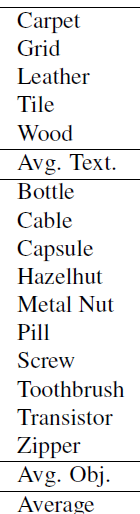
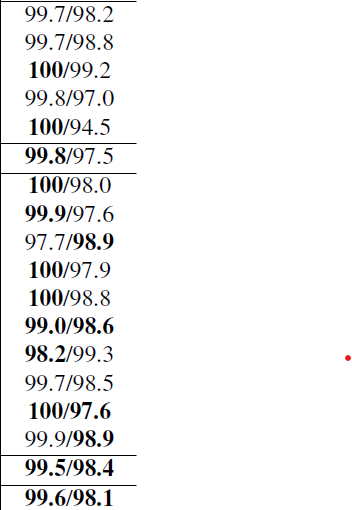

In [32]:
df = pd.DataFrame(all_best_results)
df

,dataset,instance_auroc,pixel_auroc,anomaly_pixel_auroc
0,mvtec_bottle,1.000000,0.981112,0.929705
1,mvtec_cable,1.000000,0.968182,0.894384
2,mvtec_capsule,0.955325,0.989232,0.931704
3,mvtec_carpet,0.977528,0.980834,0.921264
4,mvtec_grid,0.998329,0.983470,0.947205
5,mvtec_hazelnut,0.995357,0.974867,0.869282
6,mvtec_leather,1.000000,0.992599,0.968290
7,mvtec_metal_nut,1.000000,0.986487,0.902519
8,mvtec_pill,0.958538,0.977793,0.907334
9,mvtec_screw,0.913302,0.971269,0.852952


In [11]:
df.to_csv("best_results.csv", index=False)